In [ ]:
!pip install moviepy
!gdown https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I

Downloading...
From (original): https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I
From (redirected): https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I&confirm=t&uuid=b9b7b13f-27c3-4cf9-aae5-76e220823088
To: /content/state_normal81000.ckpt
100% 124M/124M [00:04<00:00, 29.5MB/s]


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from moviepy.editor import ImageSequenceClip
from IPython.display import Image

  if event.key is 'enter':



In [ ]:

def genSamples(g, n=8):
    with torch.no_grad():
        s = g(torch.rand((n**2, 100), device='cuda')*2-1).cpu().detach().numpy()

    out = np.zeros((3, 16, 64*n, 64*n))

    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n+k, :, :, :, :]


    out = out.transpose((1, 2, 3, 0))
    out = (out + 1) / 2 * 255
    out = out.astype(int)
    clip = ImageSequenceClip(list(out), fps=20)
    clip.write_gif('sample.gif', fps=20)

In [ ]:
batch_size = 32
num_epochs = 100
lr = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda x: (x / 255.0 - 0.5) * 2),
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2))
])

In [ ]:
dataset = UCF101(root='data', annotation_path='annotations',
                frames_per_clip=16, step_between_clips=1,
                transform=transform, fold=1, train=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
class TemporalGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose1d(100, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 100, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose1d:
            nn.init.xavier_uniform_(m.weight, gain=2**0.5)

    def forward(self, x):
        x = x.view(-1, 100, 1)
        x = self.model(x).transpose(1, 2)
        return x

In [ ]:
class VideoGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.temp = TemporalGenerator()

        self.fast = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        self.slow = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.fast.apply(self.init_weights)
        self.slow.apply(self.init_weights)
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-0.01, b=0.01)

    def forward(self, x):
        z_fast = self.temp(x).contiguous()
        z_fast = z_fast.view(-1, 100)
        z_fast = self.fast(z_fast).view(-1, 256, 4, 4)

        z_slow = self.slow(x).view(-1, 256, 4, 4).unsqueeze(1)
        z_slow = torch.cat([z_slow]*16, dim=1).view(-1, 256, 4, 4)

        z = torch.cat([z_slow, z_fast], dim=1)

        out = self.model(z)

        return out.view(-1, 16, 3, 64, 64).transpose(1, 2)

In [ ]:
class VideoDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model3d = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv3d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),
            nn.Conv3d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            nn.Conv3d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )

        self.conv2d = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

        self.model3d.apply(self.init_weights)
        self.init_weights(self.conv2d)

    def init_weights(self, m):
        if type(m) == nn.Conv3d or type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight, gain=2**0.5)

    def forward(self, x):
        h = self.model3d(x)
        h = torch.reshape(h, (32, 512, 4, 4))
        h = self.conv2d(h)
        return h

In [ ]:
gen = VideoGenerator().to(device)
dis = VideoDiscriminator().to(device)

In [ ]:
def new_dis_forward(self, x):
    h = self.model3d(x)
    h = h.squeeze(2)
    h = self.conv2d(h)
    return h.view(-1)

In [ ]:
VideoDiscriminator.forward = new_dis_forward

In [ ]:
genOpt = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disOpt = optim.Adam(dis.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Training Loop
'''
for epoch in range(num_epochs):
    for i, real_videos in enumerate(dataloader):
        real_videos = real_videos.to(device)
        current_batch = real_videos.size(0)

        dis.zero_grad()

        real_pred = dis(real_videos)
        d_loss_real = -torch.mean(real_pred)

        noise = torch.rand(current_batch, 100, device=device) * 2 - 1
        fake_videos = gen(noise)
        fake_pred = dis(fake_videos.detach())
        d_loss_fake = torch.mean(fake_pred)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        disOpt.step()

        gen.zero_grad()
        noise = torch.rand(current_batch, 100, device=device) * 2 - 1
        fake_videos = gen(noise)
        fake_pred = dis(fake_videos)
        g_loss = -torch.mean(fake_pred)
        g_loss.backward()
        genOpt.step()

        if i % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(dataloader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    if (epoch+1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': gen.state_dict(),
            'optimizer_state_dict': genOpt.state_dict()
        }, f'checkpoint_{epoch+1}.pth')

        genSamples(gen)
        print(f'Saved checkpoint and sample at epoch {epoch+1}')
'''

In [ ]:
gen = VideoGenerator().cuda()
gen.load_state_dict(torch.load('state_normal81000.ckpt')['model_state_dict'][0])
genSamples(gen)

  gen.load_state_dict(torch.load('state_normal81000.ckpt')['model_state_dict'][0])



MoviePy - Building file sample.gif with imageio.


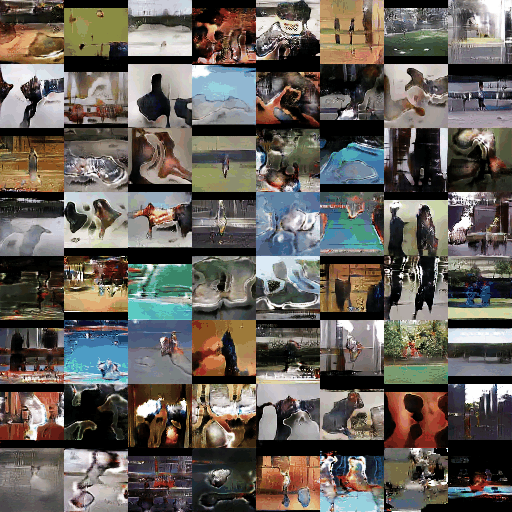

In [ ]:
Image(open('sample.gif', 'rb').read())